# Estimación de nivel de ingreso

### Data exploration

#### Carga de datos

In [1]:
import pandas as pd

data = pd.read_csv('data/ingresos.csv')


bStart, bEnd = ['\x1b[1;30m','\x1b[0m']
def bold(*phrases):
    return bStart+' '.join(str(word) for word in phrases)+bEnd

N = data.shape[0]
print('Tamaño del dataset '+bold('N:',N))

print(bold('Features ('+str(data.shape[1])+'):'))
for col in data.columns:
    if data[col].dtype.name == 'object':
        data[col] = pd.Categorical(data[col])
        print ('\t - '+col,': categóricos con #',len(data[col].cat.categories),'categorías')
    else:
        print ('\t - '+col+': numéricos en el rango [',data[col].min(),
               ',',data[col].max(),'], media:',
               "{:.1f}".format(data[col].mean()),' std:'
               "{:.1f}".format(data[col].std()))

Tamaño del dataset N: 48842
Features (15):
	 - age: numéricos en el rango [ 17 , 90 ], media: 38.6  std:13.7
	 - workclass : categóricos con # 9 categorías
	 - fnlwgt: numéricos en el rango [ 12285 , 1490400 ], media: 189664.1  std:105604.0
	 - education : categóricos con # 16 categorías
	 - educational-num: numéricos en el rango [ 1 , 16 ], media: 10.1  std:2.6
	 - marital-status : categóricos con # 7 categorías
	 - occupation : categóricos con # 15 categorías
	 - relationship : categóricos con # 6 categorías
	 - race : categóricos con # 5 categorías
	 - gender : categóricos con # 2 categorías
	 - capital-gain: numéricos en el rango [ 0 , 99999 ], media: 1079.1  std:7452.0
	 - capital-loss: numéricos en el rango [ 0 , 4356 ], media: 87.5  std:403.0
	 - hours-per-week: numéricos en el rango [ 1 , 99 ], media: 40.4  std:12.4
	 - native-country : categóricos con # 42 categorías
	 - income : categóricos con # 2 categorías


El dataset contiene tanto datos como features suficientes para realizar análisis a partir de computaciones directas o utilizando aprendizaje de máquinas.

#### Gráficos para evaluación preliminar de los datos

A continuación se presenta la distribución y ciertas estadísticas de cada feature. Para permitir un análisis visual en torno a barras, se eliminarán las features que presentan una desviación estándard muy grande en relación a su valor medio ('capital-loss', 'capital-gain', 'fnlwgt').

<Figure size 640x480 with 0 Axes>

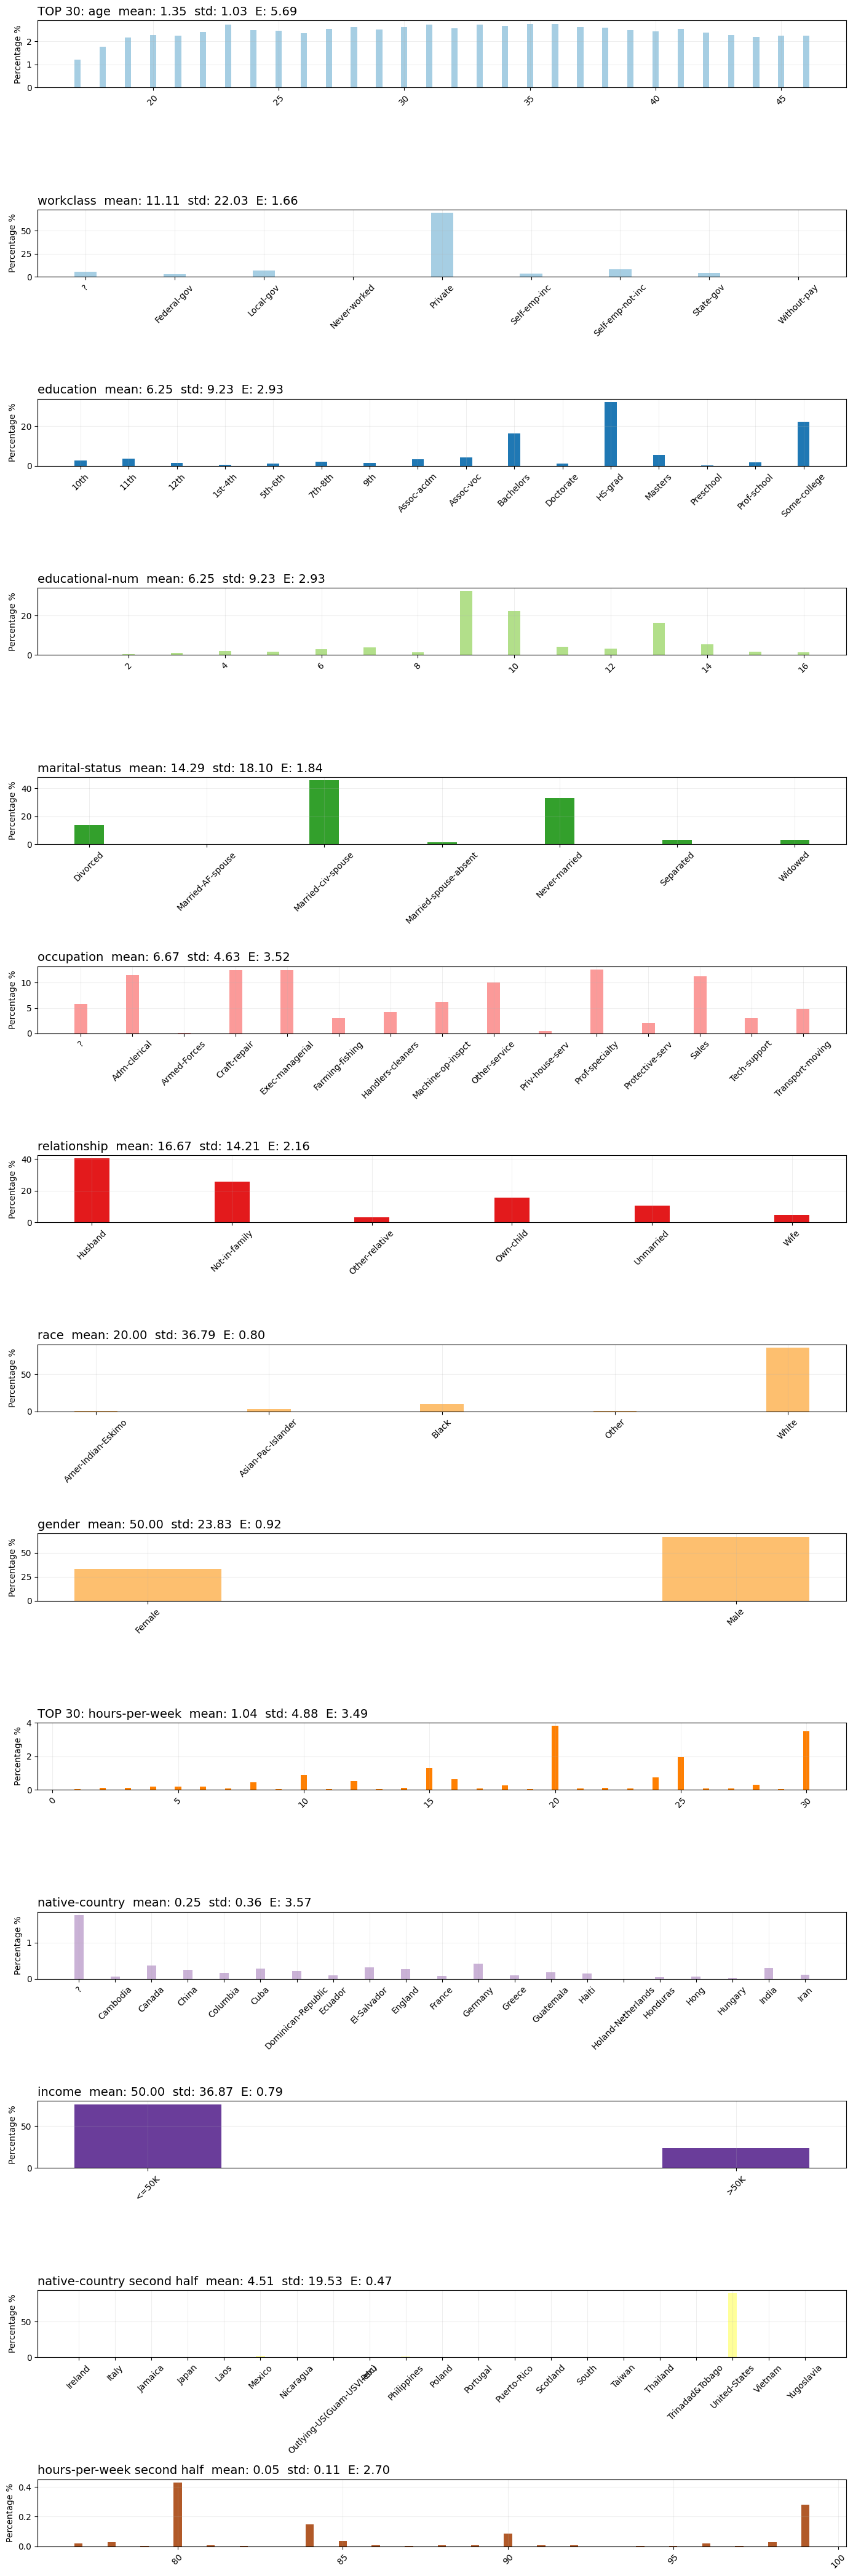

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np
import matplotlib.cm as cm

cmap = cm.get_cmap('Paired')

data['last-native-country'] = data['native-country']
data['last-hours-per-week'] = data['hours-per-week']
toShow = []
avoid = ['capital-gain', 'capital-loss', 'fnlwgt']
for col in data.columns.values:
    if col in avoid:
        continue
    toShow.append(col)
            
nPlots = len(toShow)

plt.set_cmap('Paired')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

colors = [cmap(iC/nPlots) for iC in range(nPlots)]

fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

total = data.shape[0]
usePercentage = True


for col,ax,color in zip(toShow,axs,colors):
    if 'last-' in col:
        title = col.replace('last-','') + ' second half'
        vCounts = data[col].value_counts().sort_index()[-21:]
    else:
        title = col
        if data[col].dtype.name == 'category':
            vCounts = data[col].value_counts().sort_index()[:21]
        else:
            vCounts = data[col].value_counts().sort_index()
    cat = vCounts.index
    count = 100.0*vCounts.values/total if usePercentage else vCounts.values
    m,s = [np.mean(count),np.std(count,ddof=1)]
    E = entropy(vCounts.values/total, base=2)
    # sem = s/np.sqrt(total)
    title = title+'  mean: '+f'{m:.2f}'+'  std: '+f'{s:.2f}'+'  E: '+f'{E:.2f}'
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Percentage %' if usePercentage else 'Counts #')
    ax.grid(alpha=0.2)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

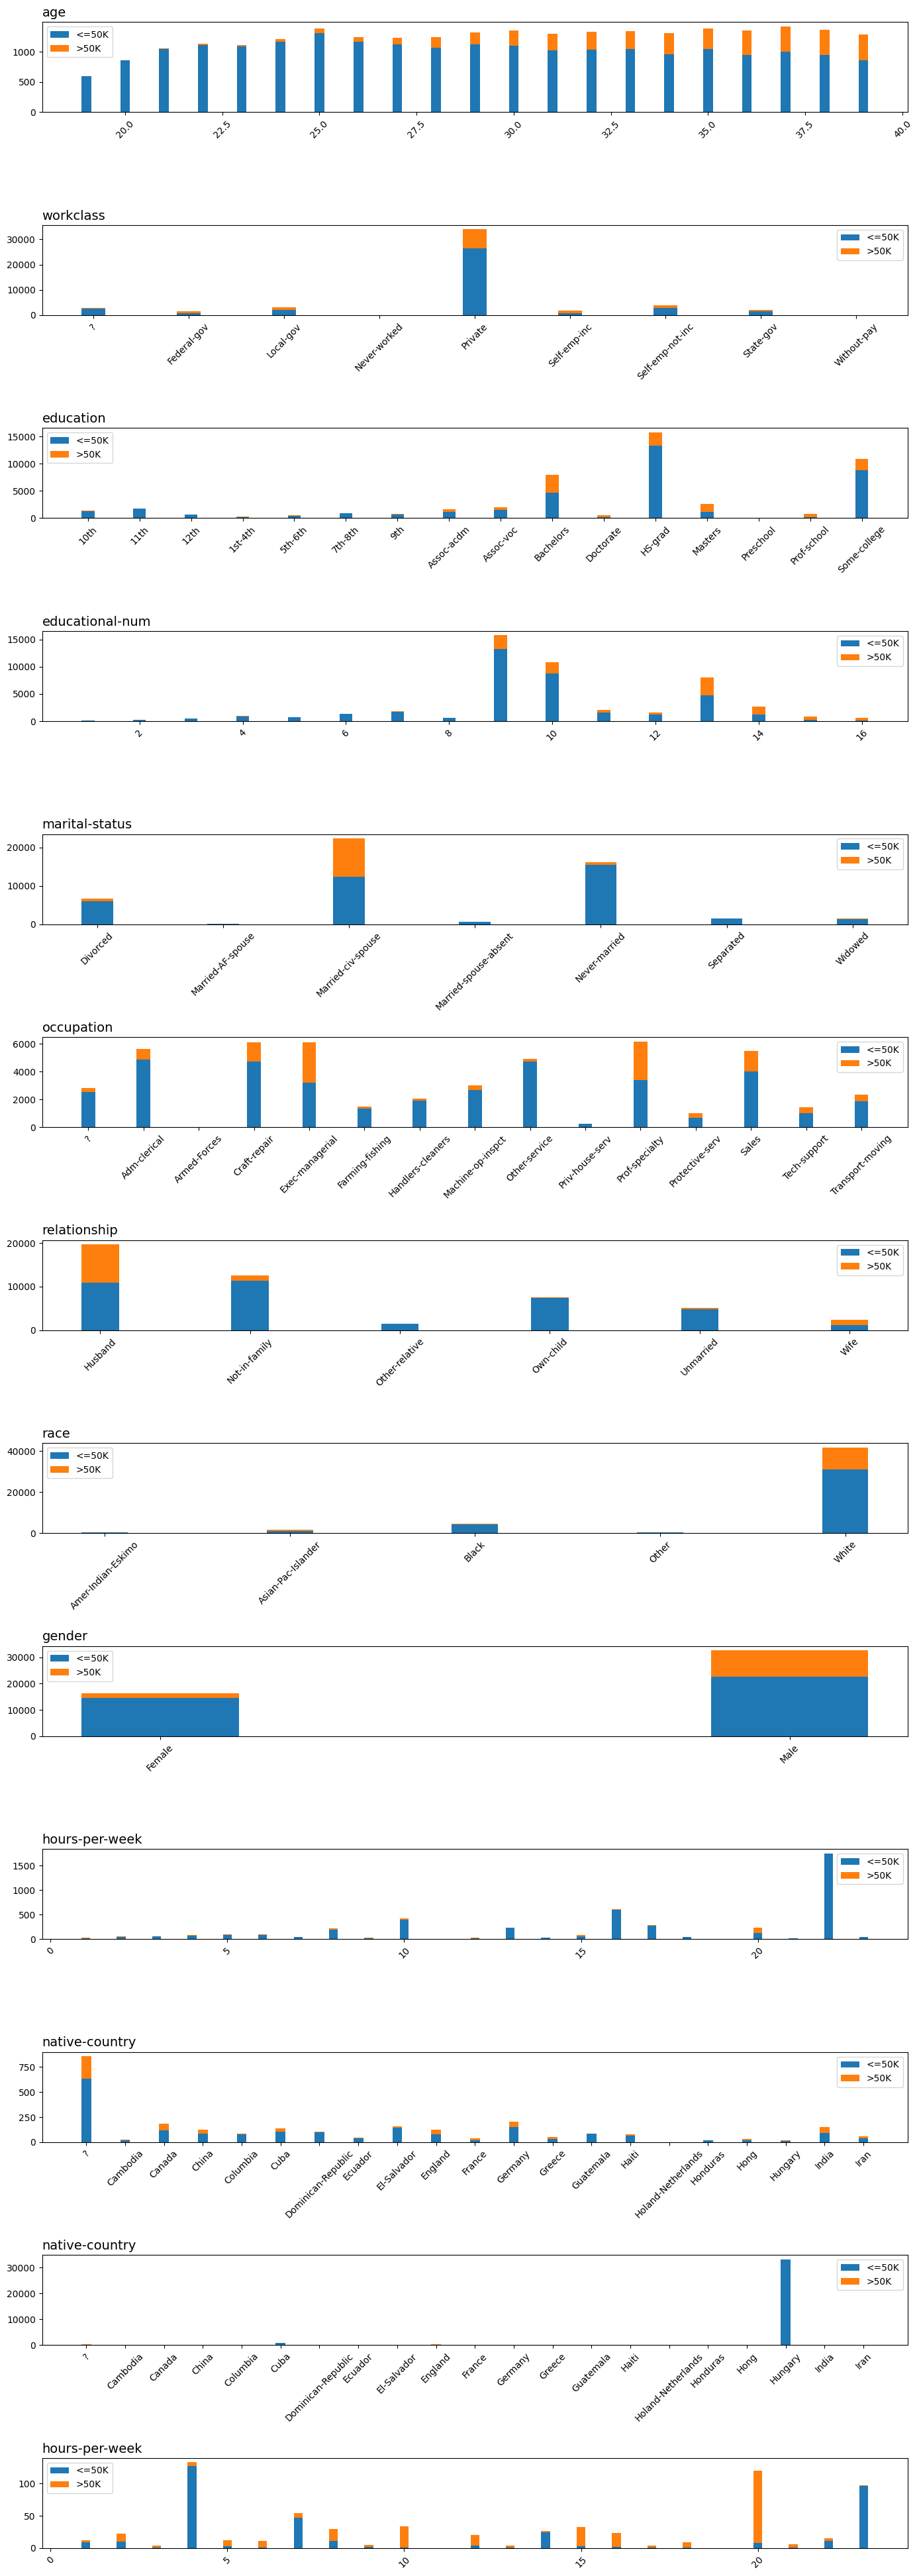

In [3]:
toShow
nPlots = len(toShow) - 1

plt.set_cmap('Paired')
colors = [cmap(iC/nPlots) for iC in range(nPlots)]

fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

incomes = ['<=50K','>50K']

i = -1
for col in toShow:
    if col == 'income':
        continue
    i += 1
    counts = []
    for iInc, inc in enumerate(incomes):
        if 'last-' in col:
            col = col.replace('last-','')
            title = col + ' second half'
            vCounts = data[col][data['income']==inc].value_counts().sort_index()[-21:]
        else:
            title = col
            vCounts = data[col][data['income']==inc].value_counts().sort_index()[:21]
        cat = vCounts.index
        counts.append(vCounts.values)
    
    axs[i].bar(cat, counts[0], width=0.25,label=incomes[0])
    axs[i].bar(cat, counts[1], width=0.25, bottom=counts[0],label=incomes[1])

    axs[i].set_title(title,fontsize=14,loc='left')
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
    axs[i].legend()

plt.tight_layout()

In [4]:
pData = data.copy()

convertToNumeric = ['race', 'gender', 'occupation','relationship','marital-status','workclass','native-country','income']

for conv in convertToNumeric:
    pData[conv] = pd.Categorical(pData[conv])
    pData[conv] = pData[conv].cat.codes
    
pData['gain+'] = 0
pData['gain-'] = 0
pData['gain'] = 1
pData['gain+'][pData['capital-gain']>0] = 1
pData['gain'][pData['capital-gain']>0] = 2
pData['gain-'][pData['capital-loss']>0] = 1
pData['gain'][pData['capital-loss']>0] = 0
pData = pData.drop(columns=['last-native-country','education'])
pData

/home/cristobal/workspace/mas-analytics/venv2/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/home/cristobal/workspace/mas-analytics/venv2/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/cristobal/workspace/mas-analytics/venv2/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,last-hours-per-week,gain+,gain-,gain
0,25,4,226802,7,4,7,3,2,1,0,0,40,39,0,40,0,0,1
1,38,4,89814,9,2,5,0,4,1,0,0,50,39,0,50,0,0,1
2,28,2,336951,12,2,11,0,4,1,0,0,40,39,1,40,0,0,1
3,44,4,160323,10,2,7,0,2,1,7688,0,40,39,1,40,1,0,2
4,18,0,103497,10,4,0,3,4,0,0,0,30,39,0,30,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,4,257302,12,2,13,5,4,0,0,0,38,39,0,38,0,0,1
48838,40,4,154374,9,2,7,0,4,1,0,0,40,39,1,40,0,0,1
48839,58,4,151910,9,6,1,4,4,0,0,0,40,39,0,40,0,0,1
48840,22,4,201490,9,4,1,3,4,1,0,0,20,39,0,20,0,0,1


<Figure size 640x480 with 0 Axes>

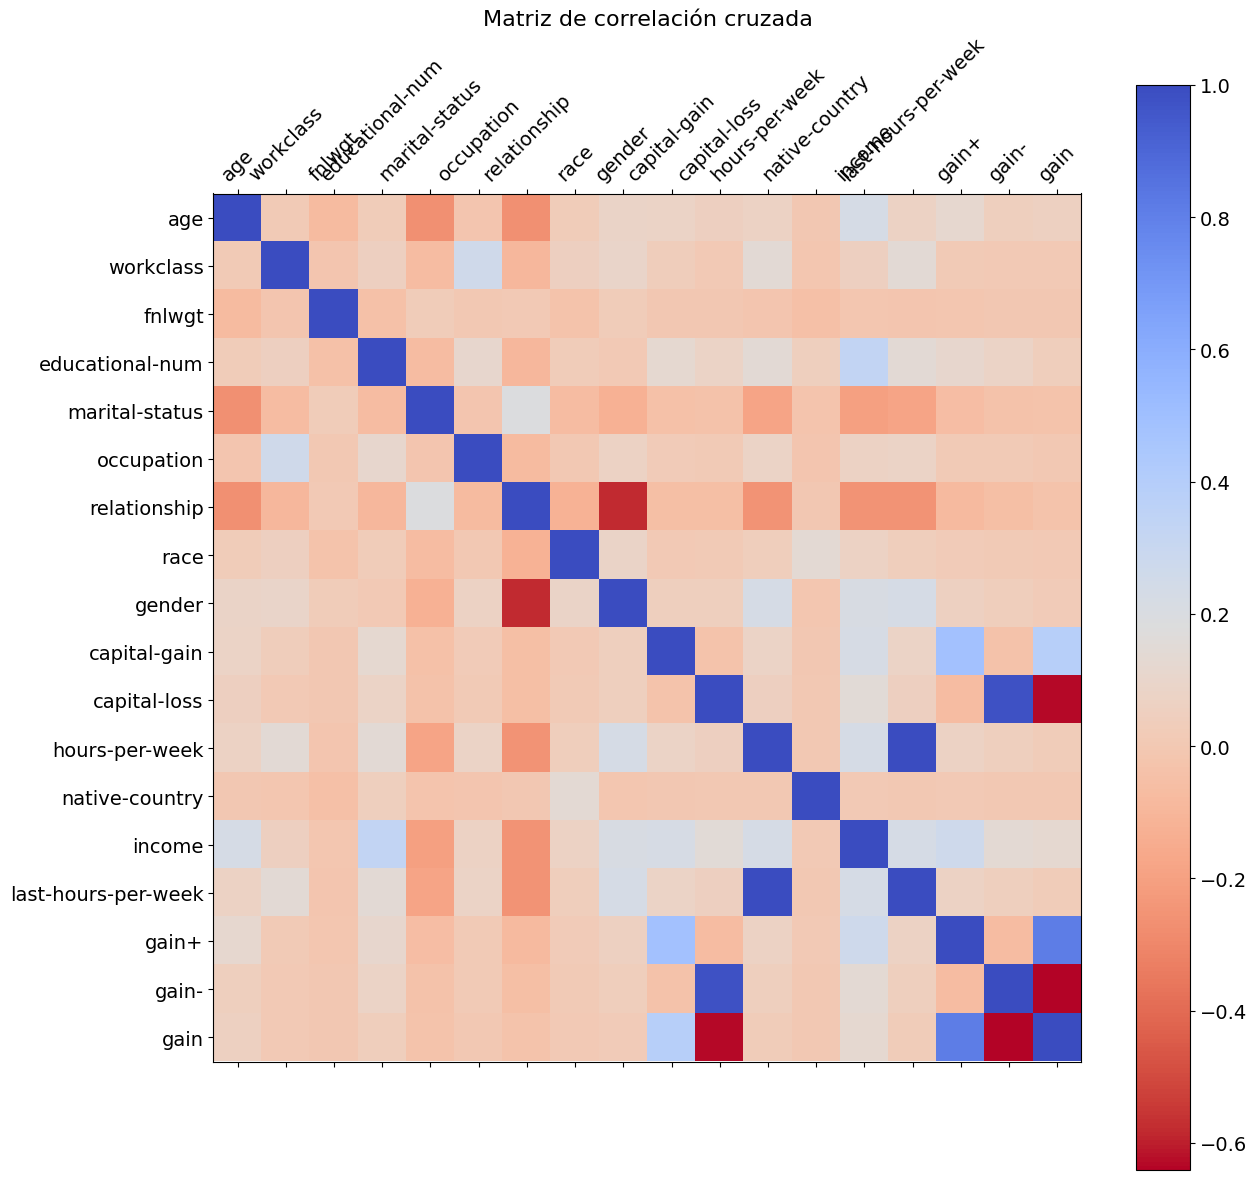

In [5]:
plt.set_cmap('coolwarm_r')
f = plt.figure(figsize=(14, 14))
plt.matshow(pData.corr(), fignum=f.number)
plt.xticks(range(pData.select_dtypes(['number']).shape[1]), pData.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(pData.select_dtypes(['number']).shape[1]), pData.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title('Matriz de correlación cruzada', fontsize=16);

Int64Index([0, 1, 2], dtype='int64')
[array([ 2.32996192, 70.5806478 ,  3.16121371]), array([ 2.34224643, 16.48581139,  5.10011875])]
Int64Index([0, 1], dtype='int64')
[array([72.91060972,  3.16121371]), array([18.82805782,  5.10011875])]
Int64Index([0, 1], dtype='int64')
[array([73.74186151,  2.32996192]), array([21.58593014,  2.34224643])]


<Figure size 640x480 with 0 Axes>

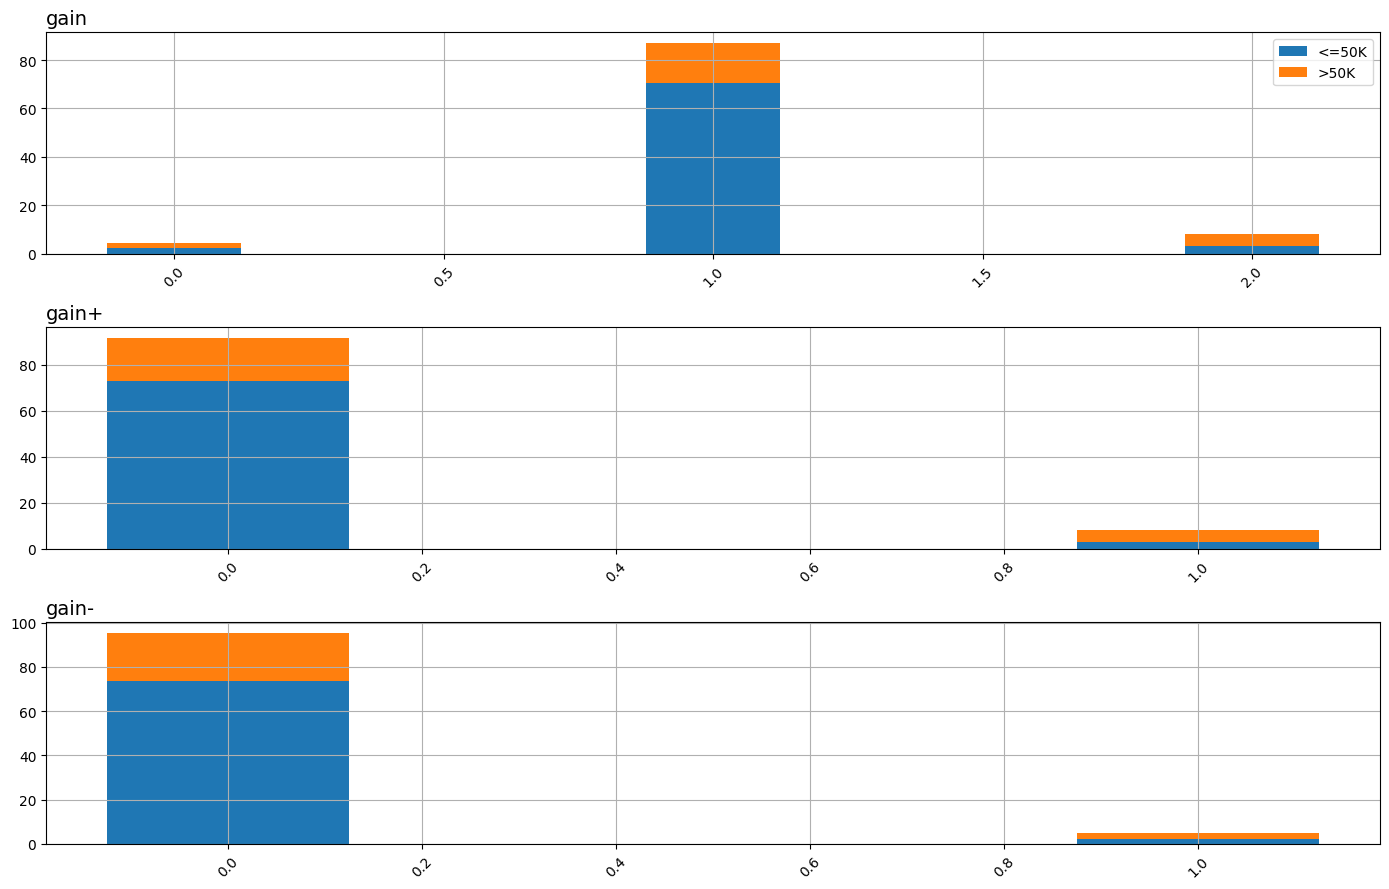

In [6]:
toShow = ['gain','gain+','gain-']
nPlots = len(toShow)

plt.set_cmap('Paired')
colors = [cmap(iC/nPlots) for iC in range(nPlots)]

fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

for i, col in enumerate(toShow):
    counts = []
    for iInc, inc in enumerate([0,1]):
        if 'last-' in col:
            col = col.replace('last-','')
            title = col + ' second half'
            vCounts = pData[col][pData['income']==inc].value_counts().sort_index()[-21:]
        else:
            title = col
            vCounts = pData[col][pData['income']==inc].value_counts().sort_index()[:21]
        cat = vCounts.index
        counts.append(100*vCounts.values/total)
    
    print(cat)
    print(counts)
    axs[i].bar(cat, counts[0], width=0.25,label=incomes[0])
    axs[i].bar(cat, counts[1], width=0.25, bottom=counts[0],label=incomes[1])

    axs[i].set_title(col,fontsize=14,loc='left')
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
    if i == 0:
        axs[i].legend()
    axs[i].grid(0.2)

plt.tight_layout()

De los datos podemos indicar que:
  - 
  - Los datos categóricos 'race', 'workclass', presentan una menor relación con el ingreso 'income' (visible en su correlación cruzada).
  - 'relationship', 'educational-num', 'marital-status' parecen estar más relaionadas al ingreso  (visible en su correlación cruzada).
  - Las distribuciones son dispersas, la mayoría de los datos parece entregar información.

### Feature selection y data pre-processing

In [7]:
features = pData.drop(columns=['income'])
output = pData['income']

avoidStardardize = ['race','gender','gain','gain+','gain-']
justScaling = ['age','hours-per-week','educational-num',
               'marital-status','occupation','race','workclass',
               'native-country', 'relationship']
for col in features.columns:
    if col in avoidStardardize:
        continue
    else:
        if col in justScaling:
            features[col] = (features[col]-features[col].min())/(features[col].max()-features[col].min())
        else:
            features[col] = (features[col]-features[col].mean())/features[col].std()
            features[col] = (features[col]-features[col].min())/(features[col].max()-features[col].min())
    # if features[col].min() < 0:
    #     features[col] = features[col] + np.abs(features[col].min())
    
    print(col,features[col].min(),features[col].max())
        
features

age 0.0 1.0
workclass 0.0 1.0
fnlwgt 0.0 1.0
educational-num 0.0 1.0
marital-status 0.0 1.0
occupation 0.0 1.0
relationship 0.0 1.0
capital-gain 0.0 1.0
capital-loss 0.0 1.0
hours-per-week 0.0 1.0
native-country 0.0 1.0
last-hours-per-week 0.0 1.0


,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,last-hours-per-week,gain+,gain-,gain
0,0.109589,0.500,0.145129,0.400000,0.666667,0.500000,0.6,2,1,0.000000,0.0,0.397959,0.95122,0.397959,0,0,1
1,0.287671,0.500,0.052451,0.533333,0.333333,0.357143,0.0,4,1,0.000000,0.0,0.500000,0.95122,0.500000,0,0,1
2,0.150685,0.250,0.219649,0.733333,0.333333,0.785714,0.0,4,1,0.000000,0.0,0.397959,0.95122,0.397959,0,0,1
3,0.369863,0.500,0.100153,0.600000,0.333333,0.500000,0.0,2,1,0.076881,0.0,0.397959,0.95122,0.397959,1,0,2
4,0.013699,0.000,0.061708,0.600000,0.666667,0.000000,0.6,4,0,0.000000,0.0,0.295918,0.95122,0.295918,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.136986,0.500,0.165763,0.733333,0.333333,0.928571,1.0,4,0,0.000000,0.0,0.377551,0.95122,0.377551,0,0,1
48838,0.315068,0.500,0.096129,0.533333,0.333333,0.500000,0.0,4,1,0.000000,0.0,0.397959,0.95122,0.397959,0,0,1
48839,0.561644,0.500,0.094462,0.533333,1.000000,0.071429,0.8,4,0,0.000000,0.0,0.397959,0.95122,0.397959,0,0,1
48840,0.068493,0.500,0.128004,0.533333,0.666667,0.071429,0.6,4,1,0.000000,0.0,0.193878,0.95122,0.193878,0,0,1


#### Chi2 score

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

print('Chi2 score')
X = features
y = output
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.sort_values('Score', ascending=False))

Chi2 score
                  Specs        Score
14                gain+  3168.446351
9          capital-gain  1250.111015
6          relationship  1113.892185
15                gain-   860.783152
8                gender   745.887609
10         capital-loss   453.108169
0                   age   308.382365
4        marital-status   280.020593
3       educational-num   262.284486
13  last-hours-per-week   100.631744
11       hours-per-week   100.631744
16                 gain    93.416456
5            occupation    55.873324
7                  race    47.949916
1             workclass     9.383162
12       native-country     0.292158
2                fnlwgt     0.083475


Chi2 scoe muestra una mayor correlacióń entre income y haber obtenido ganancias, y la relación de la persona. Haber presentado pérdidas, el género, la edad, estado marital y el nivel educacional presentan una relación más baja, cotribuyendo de igual manera con información.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

print('Tree classifier (entropy)')
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
scores = pd.DataFrame(cross_val_score(clf, X, y, cv=16))
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,scores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.sort_values('Score', ascending=False))


Tree classifier (entropy)
                  Specs     Score
13  last-hours-per-week  0.829948
6          relationship  0.825418
9          capital-gain  0.823125
14                gain+  0.823067
2                fnlwgt  0.818867
7                  race  0.816246
1             workclass  0.815264
4        marital-status  0.815264
11       hours-per-week  0.815203
0                   age  0.813953
8                gender  0.812971
10         capital-loss  0.812910
12       native-country  0.810616
15                gain-  0.808978
5            occupation  0.806420
3       educational-num  0.804782
16                 gain       NaN


### Modelamiento

Utilizaremos una regresión logística, aprovechando la cantidad de datos y features.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Splitting training and testing sets
x_tr, x_te, y_tr, y_te = train_test_split(features, output, test_size=0.25, random_state=1000)

classifier = LogisticRegression()

classifier.fit(x_tr,y_tr)
exp = {}
exp['score'] = classifier.score(x_te, y_te)
    
exp['prediction']     = classifier.predict(x_te)
exp['truth']          = y_te
exp['confusion']      = confusion_matrix(exp['truth'],exp['prediction'])

print(exp['confusion'])
exp['tp']             = exp['confusion'][1][1]
exp['tn']             = exp['confusion'][0][0]
exp['fp']             = exp['confusion'][0][1]
exp['fn']             = exp['confusion'][1][0]
exp['N']              = np.sum(exp['confusion'])
        
if 'confusion' in exp:
        # print('True negatives: ',exp[-1]['tn'])        
        # print('False positives: ',exp[-1]['fp'])        
        # print('False negatives: ',exp[-1]['fn'])    
        # print('True positives: ',exp[-1]['tp'])        
    print('Accuracy: ',(exp['tn']+exp['tp'])/exp['N'])
    print('Precision: ',exp['tp']/(exp['tp']+exp['fp']))
    print('Recall: ',exp['tp']/(exp['tp']+exp['fn']))

[[8755  514]
 [1649 1293]]
Accuracy:  0.8228646302514127
Precision:  0.7155506364139458
Recall:  0.43949694085656016


/home/cristobal/workspace/mas-analytics/venv2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [11]:
# Segunda propuesta en análisis
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input, metrics
from tensorflow.keras.backend import clear_session

xtr, xte, ytr, yte = train_test_split(features, output, test_size=0.25, random_state=42)

model = Sequential()
model.add(Input(shape=(features.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

useMetrics = ['accuracy']
predictions = []
histories = []
for m in useMetrics:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[m])
    model.summary()

    histories.append(model.fit(xtr,ytr,epochs=100,validation_data=(xte,yte)))#,verbose=True
    predictions.append(model.predict(features))

2022-08-26 16:50:13.940149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 16:50:13.940178: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-26 16:50:57.016505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-26 16:50:57.016566: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 16:50:57.016610: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dell): /proc/driver/nvidia/version does not exist
2022-08-26 16:50:57.074153: I tensorflow/core/platform/cpu_feature_guard

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1145/1145 [==============================] - 7s 2ms/step - loss: 0.4278 - accuracy: 0.8003 - val_loss: 0.3678 - val_accuracy: 0.8307
Epoch 2/100
1145/1145 [==============================] - 3s 2ms/step - loss: 0.3580 - accuracy: 0.8317 - val_loss: 0.3318 - val_accuracy: 0.8487
Epoch 3/100
1145/1145 [=====

1145/1145 [==============================] - 2s 2ms/step - loss: 0.3135 - accuracy: 0.8503 - val_loss: 0.3067 - val_accuracy: 0.8623
Epoch 52/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.3129 - accuracy: 0.8502 - val_loss: 0.3060 - val_accuracy: 0.8599
Epoch 53/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.3125 - accuracy: 0.8517 - val_loss: 0.3104 - val_accuracy: 0.8600
Epoch 54/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.3125 - accuracy: 0.8506 - val_loss: 0.3093 - val_accuracy: 0.8593
Epoch 55/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.3134 - accuracy: 0.8502 - val_loss: 0.3091 - val_accuracy: 0.8588
Epoch 56/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.3128 - accuracy: 0.8508 - val_loss: 0.3076 - val_accuracy: 0.8600
Epoch 57/100
1145/1145 [==============================] - 2s 2ms/step - loss: 0.3121 - accuracy: 0.8506 - val_loss: 0.3091 - val_accuracy

## Resultados

Se logra una clasificación, utilizando una regresión lineal, con un accuracy del 82% de los casos, demostrando el poder de clasificatión del algoritmo para el dataset entregado. Este resultado es mejorado (87%) utilizando una red neuronal fully connected de 2 hidden-layers. Es decir, 17 de 20 datos son clasificados correctamente.